# Prévisions météorologiques en Australie

# Analyses et prédictions d'une série temporelle

## Récupération des librairies

In [1]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

## Récupération du jeu de données et analyse d'une série temporelle

### Définition et analyse du jeu de données général

In [2]:
# récupération du jeu de données après prétraitement et avant l'étape de classification des villes en fonction du climat
df = pd.read_csv('../data/weatherAUS_preprocessed_before_city_clust.csv', header=0, parse_dates=[0], squeeze=True)
df.head()

,Date,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
0,2008-12-01,Albury,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0
1,2008-12-02,Albury,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0
2,2008-12-03,Albury,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0
3,2008-12-04,Albury,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0
4,2008-12-05,Albury,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0


In [3]:
# analyse statistique rapide du DataFrame
df.describe()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
count,140787.000000,140787.000000,140787.000000,140787.00000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000,140787.000000
mean,0.485723,7.464155,39.774027,51.45039,1017.675010,4.508919,21.704255,0.221618,11.047056,-17.432103
std,0.791851,3.180147,12.945712,20.80663,7.020096,2.217188,6.915140,0.415337,4.955324,16.392319
min,0.000000,0.000000,6.000000,0.00000,998.650000,0.000000,1.900000,0.000000,-3.750000,-63.500000
25%,0.000000,6.160000,31.000000,37.00000,1012.900000,3.000000,16.600000,0.000000,7.200000,-29.000000
50%,0.000000,7.630540,39.000000,52.00000,1017.600000,4.499250,21.100000,0.000000,10.500000,-17.000000
75%,0.800000,9.680000,48.000000,66.00000,1022.400000,6.000000,26.400000,0.000000,14.500000,-6.000000
max,2.000000,14.500000,73.500000,100.00000,1036.650000,9.000000,41.100000,1.000000,25.450000,28.500000


In [4]:
# récupération du jeu de données relatif au climat
aus_climats = pd.read_csv("../data/climatsAUS_v2.csv",sep=";")
aus_climats.head()

,Location,Climat_Koppen
0,Uluru,BSh
1,Woomera,Bwh
2,Adelaide,Csa
3,Albany,Csb
4,MountGambier,Csb


In [5]:
# regroupement des climats en 4 catégories: "chaud_humide", "tempéré_froid", "sec" et "méditerranéen" 
climats_type = {'Am':'chaud_humide',
                'Aw':'chaud_humide',
                'Cfa':'chaud_humide',
                'Cfb':'tempéré_froid', 
                'Cfc':'tempéré_froid', 
                'BSh':'sec',
                'BSk':'sec',
                'Bsk':'sec', 
                'Bwh':'sec',
                'Csa':'méditerranéen',
                'Csb':'méditerranéen'}

aus_climats['Clim_type'] = aus_climats['Climat_Koppen'].map(climats_type)

In [6]:
# aperçu du jeu de données relatif au climat
aus_climats.describe()

,Location,Climat_Koppen,Clim_type
count,49,49,49
unique,49,11,4
top,Uluru,Cfa,chaud_humide
freq,1,15,19


In [7]:
# intégration du climat australien dans le DataFrame étudié
df = pd.merge(df, aus_climats, how='left', left_on="Location", right_on="Location")

In [8]:
df.head()

,Date,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,Climat_Koppen,Clim_type
0,2008-12-01,Albury,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0,Cfa,chaud_humide
1,2008-12-02,Albury,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0,Cfa,chaud_humide
2,2008-12-03,Albury,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0,Cfa,chaud_humide
3,2008-12-04,Albury,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0,Cfa,chaud_humide
4,2008-12-05,Albury,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0,Cfa,chaud_humide


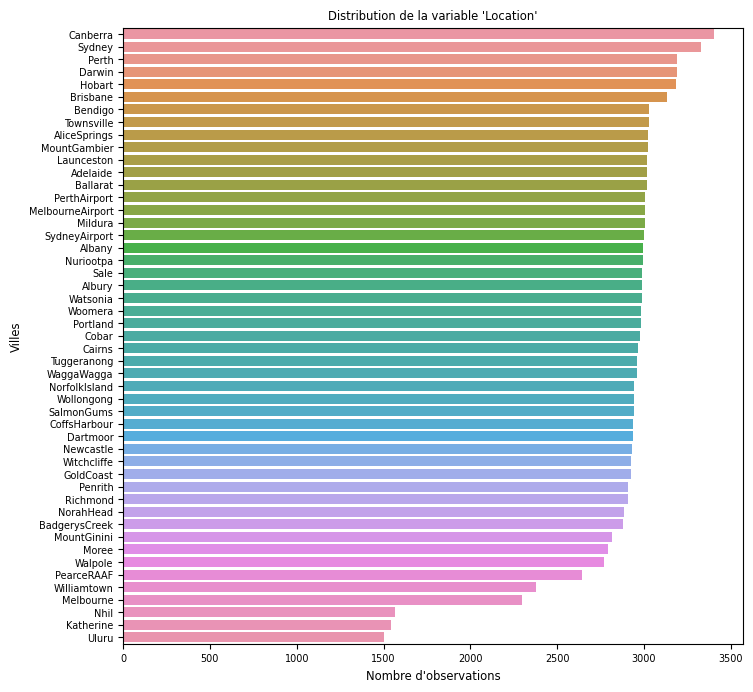

In [9]:
# distribution de la variable 'Location'
plt.figure(figsize=(8,8))
ax = sns.countplot(y=df['Location'], order=df['Location'].value_counts().index)
ax.set_title("Distribution de la variable 'Location'", fontsize="small")
ax.set_ylabel('Villes', fontsize="small")
ax.set_xlabel("Nombre d'observations", fontsize="small")
ax.tick_params(labelsize=7);

In [10]:
# définition du nombre minimal d'observations requis pour regrouper les villes par type de climat
obs_min = 2500 

In [11]:
# création d'un index relatif aux villes possédant un nombre suffisant d'observations
location = df.groupby(['Location'])['Location'].count().sort_values() > obs_min
location = location[location.values==True].index

### Définition et analyse du jeu de données filtré

In [12]:
# définition du DataFrame relatif aux villes possédant un nombre suffisant d'observations
df_cities = df[(df['Location'].isin(location))]

In [13]:
# aperçu du DataFrame
df_cities.head()

,Date,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,Climat_Koppen,Clim_type
0,2008-12-01,Albury,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0,Cfa,chaud_humide
1,2008-12-02,Albury,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0,Cfa,chaud_humide
2,2008-12-03,Albury,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0,Cfa,chaud_humide
3,2008-12-04,Albury,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0,Cfa,chaud_humide
4,2008-12-05,Albury,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0,Cfa,chaud_humide


In [14]:
# analyse statistique rapide du DataFrame
df_cities.describe()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta
count,131501.000000,131501.000000,131501.000000,131501.000000,131501.000000,131501.000000,131501.000000,131501.000000,131501.000000,131501.000000
mean,0.490061,7.465856,39.620596,51.877339,1017.714389,4.509321,21.572157,0.224264,10.950300,-17.302218
std,0.793838,3.188442,12.942699,20.724410,7.025030,2.224650,6.844380,0.417099,4.922511,16.375607
min,0.000000,0.000000,6.000000,0.000000,998.650000,0.000000,1.900000,0.000000,-3.750000,-63.500000
25%,0.000000,6.100000,31.000000,37.000000,1013.000000,3.000000,16.600000,0.000000,7.100000,-28.000000
50%,0.000000,7.630540,39.000000,52.000000,1017.700000,4.499250,21.000000,0.000000,10.400000,-17.000000
75%,0.800000,9.700000,48.000000,66.000000,1022.400000,6.000000,26.300000,0.000000,14.400000,-6.000000
max,2.000000,14.500000,73.500000,100.000000,1036.650000,9.000000,41.100000,1.000000,25.450000,28.500000


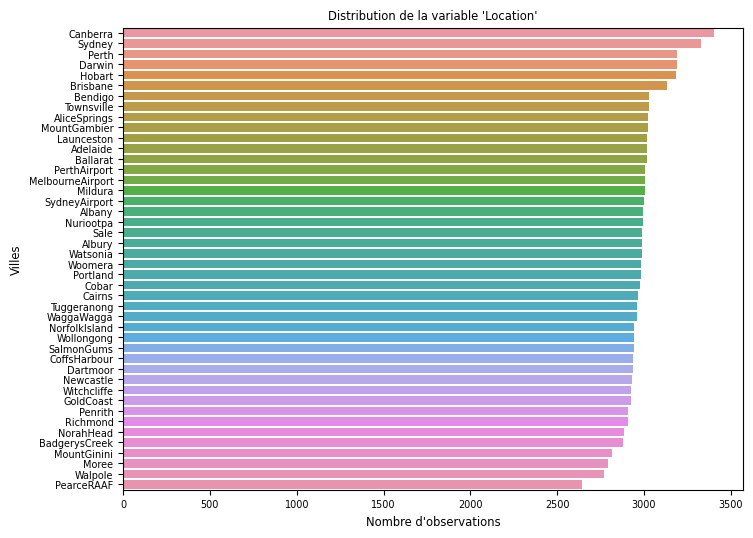

In [15]:
# distribution de la variable 'Location' pour les villes possédant un nombre suffisant d'observations
plt.figure(figsize=(8,6))
ax = sns.countplot(y=df_cities.Location, order=df_cities.Location.value_counts().index)
ax.set_title("Distribution de la variable 'Location'", fontsize="small")
ax.set_ylabel('Villes', fontsize="small")
ax.set_xlabel("Nombre d'observations", fontsize="small")
ax.tick_params(labelsize=7);

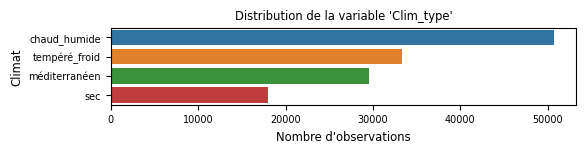

In [16]:
# distribution de la variable 'Clim_type' pour les villes possédant un nombre suffisant d'observations
ax = plt.figure(figsize=(6,1))
ax = sns.countplot(y=df_cities.Clim_type, order=df_cities.Clim_type.value_counts().index)
ax.set_title("Distribution de la variable 'Clim_type'", fontsize="small")
ax.set_ylabel('Climat', fontsize="small")
ax.set_xlabel("Nombre d'observations", fontsize="small")
ax.tick_params(labelsize=7);

In [17]:
# récupération du type de climat possédant le plus d'observations pour les villes sélectionnées
climate_with_max_obs = df_cities.Clim_type.value_counts(ascending=False).idxmax()
print("Climat possédant le plus d'observations pour les villes sélectionnées : ", climate_with_max_obs)

Climat possédant le plus d'observations pour les villes sélectionnées :  chaud_humide


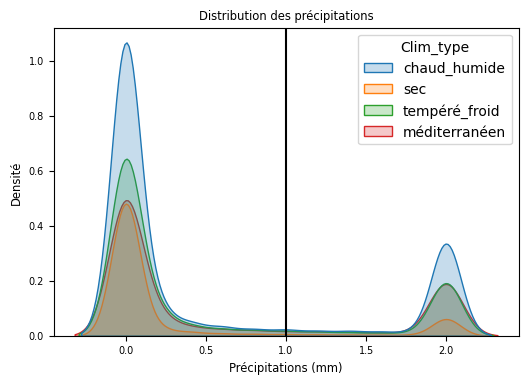

In [18]:
# distribution des précipitations selon le type de climat pour les villes possédant un nombre suffisant d'observations
plt.figure(figsize=(6,4))
ax = sns.kdeplot(df_cities['Rainfall'], shade='True', hue=df_cities['Clim_type'])
ax.set_title("Distribution des précipitations", fontsize="small")
ax.set_ylabel('Densité', fontsize="small")
ax.set_xlabel("Précipitations (mm)", fontsize="small")
plt.axvline(x=1, color='black')
ax.tick_params(labelsize=7);

In [19]:
# remplacement de l'index du DataFrame par conversion de la variable "Date" au format datetime
df_cities['Date'] = pd.to_datetime(df_cities['Date'])
df_cities['month'] = pd.to_datetime(df_cities['Date']).dt.month
df_cities['year'] = pd.to_datetime(df_cities['Date']).dt.year
df_cities.set_index(['Date'], inplace=True)

In [20]:
# aperçu du DataFrame
df_cities.head()

,Location,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,RainTomorrow,Temp_Delta_MinMax,Humidity_Delta,Climat_Koppen,Clim_type,month,year
Date,,,,,,,,,,,,,,,
2008-12-01,Albury,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,0,9.5,-49.0,Cfa,chaud_humide,12,2008
2008-12-02,Albury,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,0,17.7,-19.0,Cfa,chaud_humide,12,2008
2008-12-03,Albury,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,0,12.8,-8.0,Cfa,chaud_humide,12,2008
2008-12-04,Albury,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,0,18.8,-29.0,Cfa,chaud_humide,12,2008
2008-12-05,Albury,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,0,14.8,-49.0,Cfa,chaud_humide,12,2008


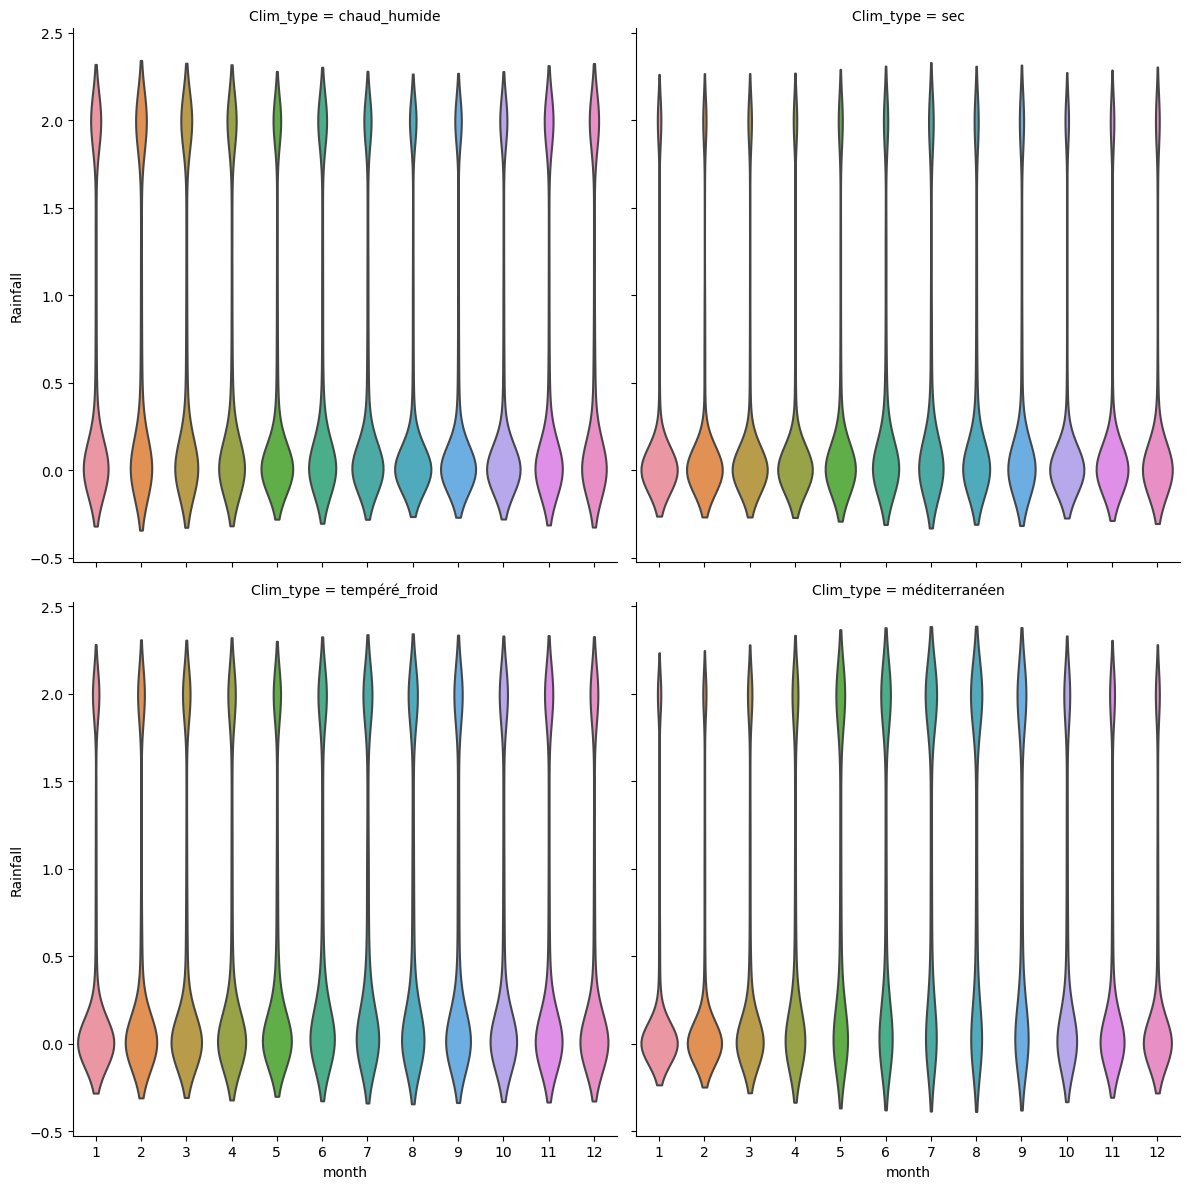

In [21]:
# distribution des précipitations avec les courbes de densité pour chaque modalité de la variable "Clim_type" 
# et pour chaque mois de la période observée
sns.catplot(kind='violin', x='month', y='Rainfall', data=df_cities, col='Clim_type', inner=None, height=6, col_wrap=2);

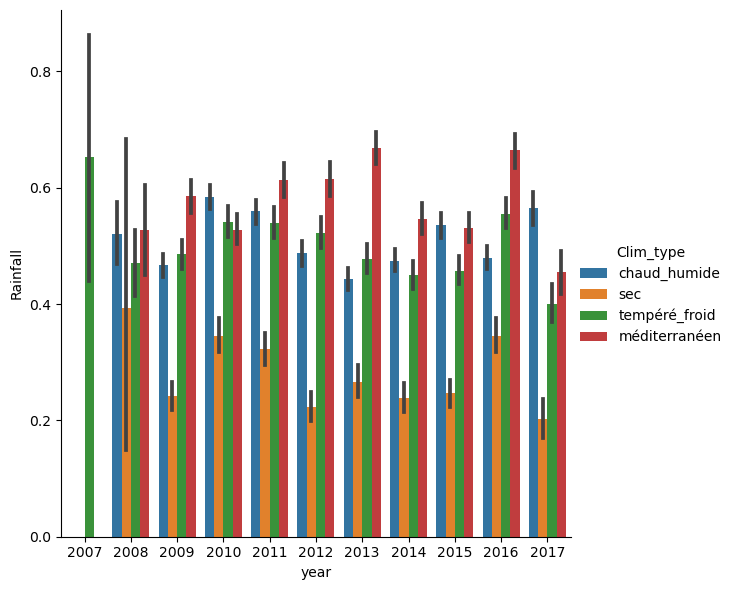

In [22]:
# graphique en barres des précipitations selon les modalités de la variable "Clim_type"
sns.catplot(x='year', y='Rainfall', kind='bar', height=6, hue='Clim_type', data=df_cities);

In [23]:
pd.crosstab(df_cities.year, df_cities.Clim_type).sort_values(by='year', ascending=True)

Clim_type,chaud_humide,méditerranéen,sec,tempéré_froid
year,,,,
2007,0,0,0,61
2008,881,400,31,733
2009,6135,3497,2184,3970
2010,5968,3584,2139,3793
2011,5635,3222,2000,3638
2012,5610,3187,2004,3640
2013,5659,3218,2013,3684
2014,6009,3505,2186,3976
2015,5982,3602,2182,3980


### Définition de la série temporelle générale

In [24]:
# réorganisation des données du DataFrame en calculant les précipitations moyennées pour chaque type de climat
data_all = pd.pivot_table(df, index=['Date'], columns=['Clim_type'], values=['Rainfall'], aggfunc=np.mean).reset_index()

In [25]:
# remplacement de l'index du DataFrame par conversion de la variable "Date" au format datetime
data_all['Date'] = pd.to_datetime(data_all['Date'])
data_all.set_index(['Date'], inplace=True)

In [26]:
data_all.head()

Rainfall                                
Clim_type  chaud_humide méditerranéen sec tempéré_froid
Date                                                   
2007-11-01          NaN           NaN NaN           0.0
2007-11-02          NaN           NaN NaN           2.0
2007-11-03          NaN           NaN NaN           2.0
2007-11-04          NaN           NaN NaN           2.0
2007-11-05          NaN           NaN NaN           2.0

In [27]:
# remplacement des précipitations manquantes journalières par propagation de la dernière observation valide
data_all = data_all.resample('d').mean().ffill()

### Définition de la série temporelle filtrée

In [28]:
# création d'un DataFrame regroupant les précipitations des villes possédant un nombre suffisant d'observations
data_max_obs = df_cities[['year','Rainfall','Clim_type']]

In [29]:
# filtrage du DataFrame selon le climat possédant le plus d'observations pour les villes sélectionnées
data_max_obs = data_max_obs[data_max_obs['Clim_type'] == climate_with_max_obs]

In [30]:
# remplacement du nom de la colonne en prenant en compte le type de climat étudié
data_max_obs.rename({'Rainfall': 'Rainfall_'+climate_with_max_obs}, axis=1, inplace=True)

In [31]:
# aperçu du DataFrame
data_max_obs.head()

,year,Rainfall_chaud_humide,Clim_type
Date,,,
2008-12-01,2008,0.6,chaud_humide
2008-12-02,2008,0.0,chaud_humide
2008-12-03,2008,0.0,chaud_humide
2008-12-04,2008,0.0,chaud_humide
2008-12-05,2008,1.0,chaud_humide


In [32]:
# répartition du nombre d'observations dans le DataFrame selon l'année
pd.crosstab(data_max_obs.year, data_max_obs.Clim_type).sort_values(by='year', ascending=True)

Clim_type,chaud_humide
year,
2008,881
2009,6135
2010,5968
2011,5635
2012,5610
2013,5659
2014,6009
2015,5982
2016,5970


In [33]:
# suppression des colonnes inutiles du DataFrame
data_max_obs = data_max_obs.drop(['year','Clim_type'], axis=1)

In [34]:
# analyse statistique rapide du DataFrame
data_max_obs.describe()

,Rainfall_chaud_humide
count,50706.000000
mean,0.507561
std,0.810545
min,0.000000
25%,0.000000
50%,0.000000
75%,0.800000
max,2.000000


In [35]:
# remplacement des précipitations manquantes journalières par propagation de la dernière observation valide
data_max_obs = data_max_obs.resample('d').mean().ffill()

### Ré-échantillonage sur une base hebdomadaire moyennée

#### Série temporelle générale

In [36]:
# ré-échantillonage des données de la série temporelle générale sur une base hebdomadaire moyennée
data_week = data_all.resample('W').mean()

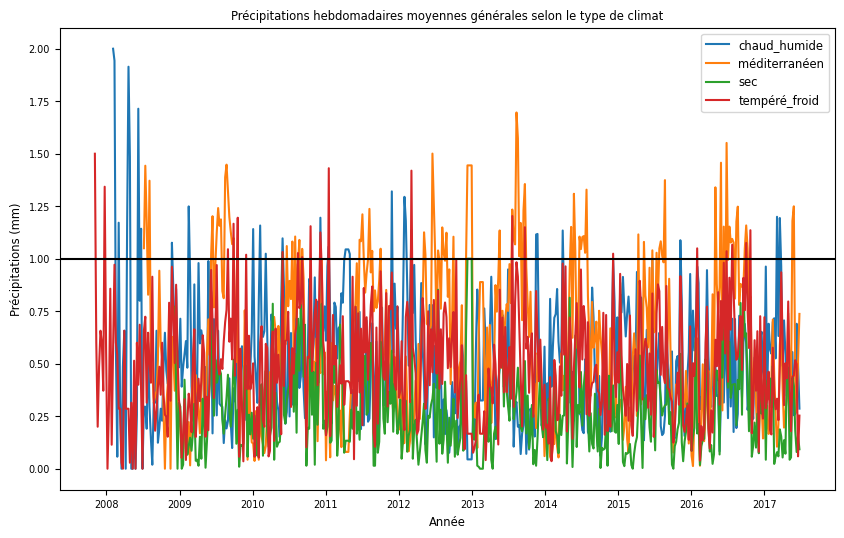

In [37]:
# affichage des précipitations moyennes hebdomadaires générales par type de climat sur la période d'observation
plt.figure(figsize=(10,6))
plt.plot(data_week, label=data_week.columns.droplevel())
plt.title('Précipitations hebdomadaires moyennes générales selon le type de climat', fontsize="small")
plt.xlabel('Année', fontsize="small")
plt.ylabel('Précipitations (mm)', fontsize="small")
plt.axhline(y=1, color='black')
plt.legend(fontsize="small")
plt.tick_params(labelsize=7);

#### Série temporelle filtrée

In [38]:
# ré-échantillonage des données de la série temporelle sur une base hebdomadaire moyennée
data_max_obs_week = data_max_obs.resample('W').mean()

In [39]:
# analyse statistique rapide du DataFrame "data"
data_max_obs_week.describe()

,Rainfall_chaud_humide
count,491.000000
mean,0.513978
std,0.303258
min,0.000000
25%,0.286660
50%,0.479832
75%,0.684454
max,2.000000


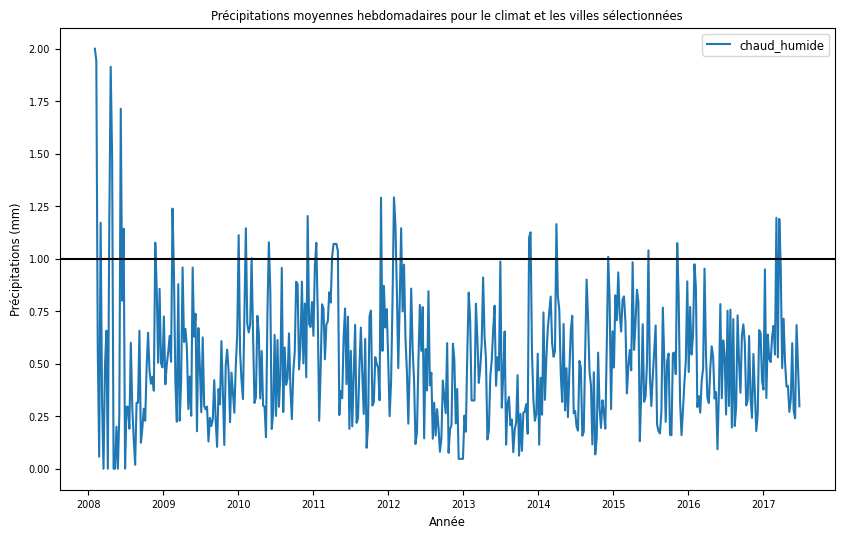

In [40]:
# affichage des précipitations moyennes hebdomadaires pour le climat et les villes sélectionnées 
# sur la période d'observation
plt.figure(figsize=(10,6))
plt.plot(data_max_obs_week, label=climate_with_max_obs)
plt.title('Précipitations moyennes hebdomadaires pour le climat et les villes sélectionnées', fontsize="small")
plt.xlabel('Année', fontsize="small")
plt.ylabel('Précipitations (mm)', fontsize="small")
plt.axhline(y=1, color='black')
plt.legend(fontsize="small")
plt.tick_params(labelsize=7);

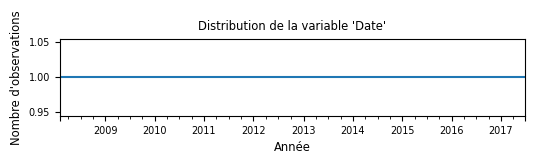

In [41]:
# affichage de la distribution de la variable 'Date'
plt.figure(figsize=(6,1))
data_max_obs_week.groupby(['Date']).size().plot()
plt.title("Distribution de la variable 'Date'", fontsize="small")
plt.xlabel("Année", fontsize="small")
plt.ylabel("Nombre d'observations", fontsize="small")
plt.tick_params(labelsize=7);

- la série temporelle filtrée couvre bien toute la période considérée.

In [42]:
# récupération des variables "Date" et "year" dans le DataFrame
data_max_obs_week['Date'] = data_max_obs_week.index
data_max_obs_week['Date'] = pd.to_datetime(data_max_obs_week['Date'])
data_max_obs_week['year'] = pd.to_datetime(data_max_obs_week['Date']).dt.year

In [43]:
# répartition du nombre de semaines d'observations selon l'année
data_max_obs_week['year'].value_counts().sort_values(ascending=True)

2017    26
2008    48
2009    52
2010    52
2011    52
2013    52
2014    52
2015    52
2016    52
2012    53
Name: year, dtype: int64

In [44]:
# récupération du nombre de semaines d'observation en 2017
weeks_in_2017 = data_max_obs_week.groupby("year").count().iloc[9,0]

In [45]:
# suppression des colonnes inutiles
data_max_obs_week = data_max_obs_week.drop(['year','Date'], axis=1)

In [46]:
# affichage de l'index du DataFrame
print(data_max_obs_week.index)

DatetimeIndex(['2008-02-03', '2008-02-10', '2008-02-17', '2008-02-24',
               '2008-03-02', '2008-03-09', '2008-03-16', '2008-03-23',
               '2008-03-30', '2008-04-06',
               ...
               '2017-04-23', '2017-04-30', '2017-05-07', '2017-05-14',
               '2017-05-21', '2017-05-28', '2017-06-04', '2017-06-11',
               '2017-06-18', '2017-06-25'],
              dtype='datetime64[ns]', name='Date', length=491, freq='W-SUN')


- La série temporelle filtrée contient des observations hebdomadaires pour la période du **3 Février 2008** au **25 Juin 2017**.

In [47]:
# suppression de l'année 2007 dans la série temporelle car elle ne semble pas significative dans notre analyse
# data_max_obs_week = data_max_obs_week.loc[pd.to_datetime('2008-01-06'):, :]

### Ré-échantillonage sur une base mensuelle moyennée

#### Série temporelle générale

In [48]:
# ré-échantillonage des données de la série temporelle générale sur une base mensuelle moyennée
data_month = data_all.resample('M').mean()

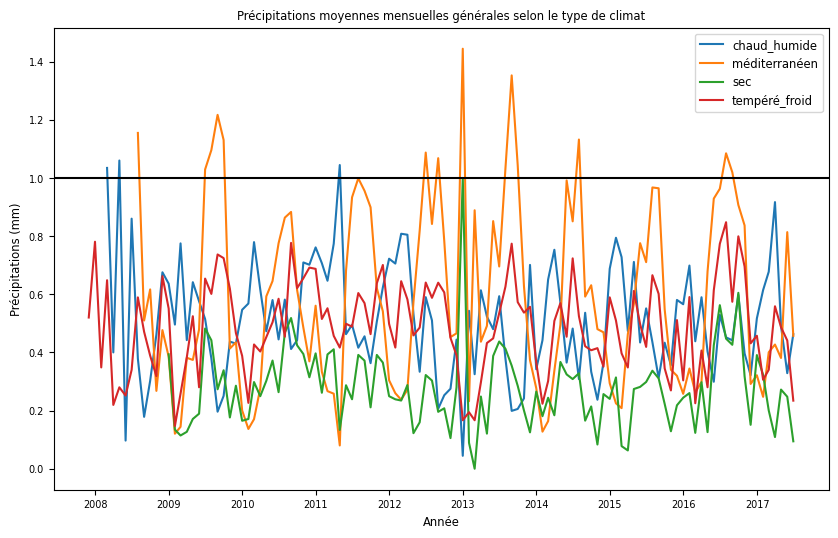

In [49]:
# affichage des précipitations moyennes mensuelles générales par type de climat sur la période d'observation
plt.figure(figsize=(10,6))
plt.plot(data_month, label=data_month.columns.droplevel())
plt.title('Précipitations moyennes mensuelles générales selon le type de climat', fontsize="small")
plt.xlabel('Année', fontsize="small")
plt.ylabel('Précipitations (mm)', fontsize="small")
plt.axhline(y=1, color='black')
plt.legend(fontsize="small")
plt.tick_params(labelsize=7);

#### Série temporelle filtrée

In [50]:
# ré-échantillonage des données de la série temporelle sur une base hebdomadaire moyennée
data_max_obs_month = data_max_obs.resample('M').mean()

In [51]:
# analyse statistique rapide du DataFrame "data"
data_max_obs_month.describe()

,Rainfall_chaud_humide
count,113.000000
mean,0.513603
std,0.193651
min,0.047059
25%,0.389730
50%,0.499668
75%,0.617008
max,1.070588


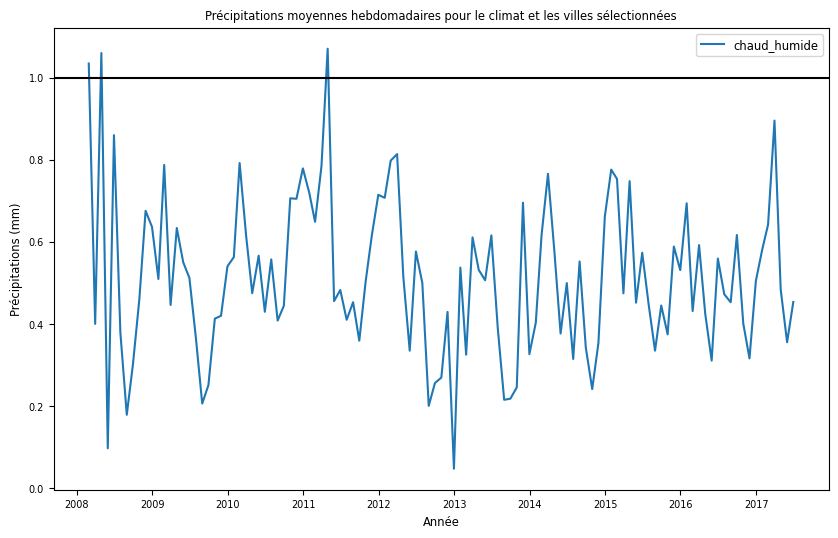

In [52]:
# affichage des précipitations moyennes hebdomadaires pour le climat et les villes sélectionnées 
# sur la période d'observation
plt.figure(figsize=(10,6))
plt.plot(data_max_obs_month, label=climate_with_max_obs)
plt.title('Précipitations moyennes hebdomadaires pour le climat et les villes sélectionnées', fontsize="small")
plt.xlabel('Année', fontsize="small")
plt.ylabel('Précipitations (mm)', fontsize="small")
plt.axhline(y=1, color='black')
plt.legend(fontsize="small")
plt.tick_params(labelsize=7);

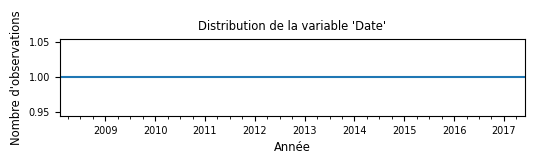

In [53]:
# affichage de la distribution de la variable 'Date'
plt.figure(figsize=(6,1))
data_max_obs_month.groupby(['Date']).size().plot()
plt.title("Distribution de la variable 'Date'", fontsize="small")
plt.xlabel("Année", fontsize="small")
plt.ylabel("Nombre d'observations", fontsize="small")
plt.tick_params(labelsize=7);

In [54]:
# récupération des variables "Date" et "year" dans le DataFrame
data_max_obs_month['Date'] = data_max_obs_month.index
data_max_obs_month['Date'] = pd.to_datetime(data_max_obs_month['Date'])
data_max_obs_month['year'] = pd.to_datetime(data_max_obs_month['Date']).dt.year

In [55]:
# répartition du nombre de mois d'observations selon l'année
data_max_obs_month['year'].value_counts().sort_values(ascending=True)

2017     6
2008    11
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
Name: year, dtype: int64

In [56]:
# récupération du nombre de mois d'observation en 2017
months_in_2017 = data_max_obs_month.groupby("year").count().iloc[9,0]

In [57]:
# suppression des colonnes inutiles
data_max_obs_month = data_max_obs_month.drop(['year','Date'], axis=1)

In [58]:
# affichage de l'index du DataFrame
print(data_max_obs_month.index)

DatetimeIndex(['2008-02-29', '2008-03-31', '2008-04-30', '2008-05-31',
               '2008-06-30', '2008-07-31', '2008-08-31', '2008-09-30',
               '2008-10-31', '2008-11-30',
               ...
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30'],
              dtype='datetime64[ns]', name='Date', length=113, freq='M')


- La série temporelle filtrée contient des observations mensuelles pour la période du **29 Février 2008** au **30 Juin 2017**.

In [59]:
# suppression de l'année 2007 dans la série temporelle car elle ne semble pas significative dans notre analyse
# data_max_obs_month = data_max_obs_month.loc[pd.to_datetime('2008-01-31'):, :]

## Décomposition automatique de la série temporelle

### Série ré-échantillonnée sur une base hebdomadaire moyennée

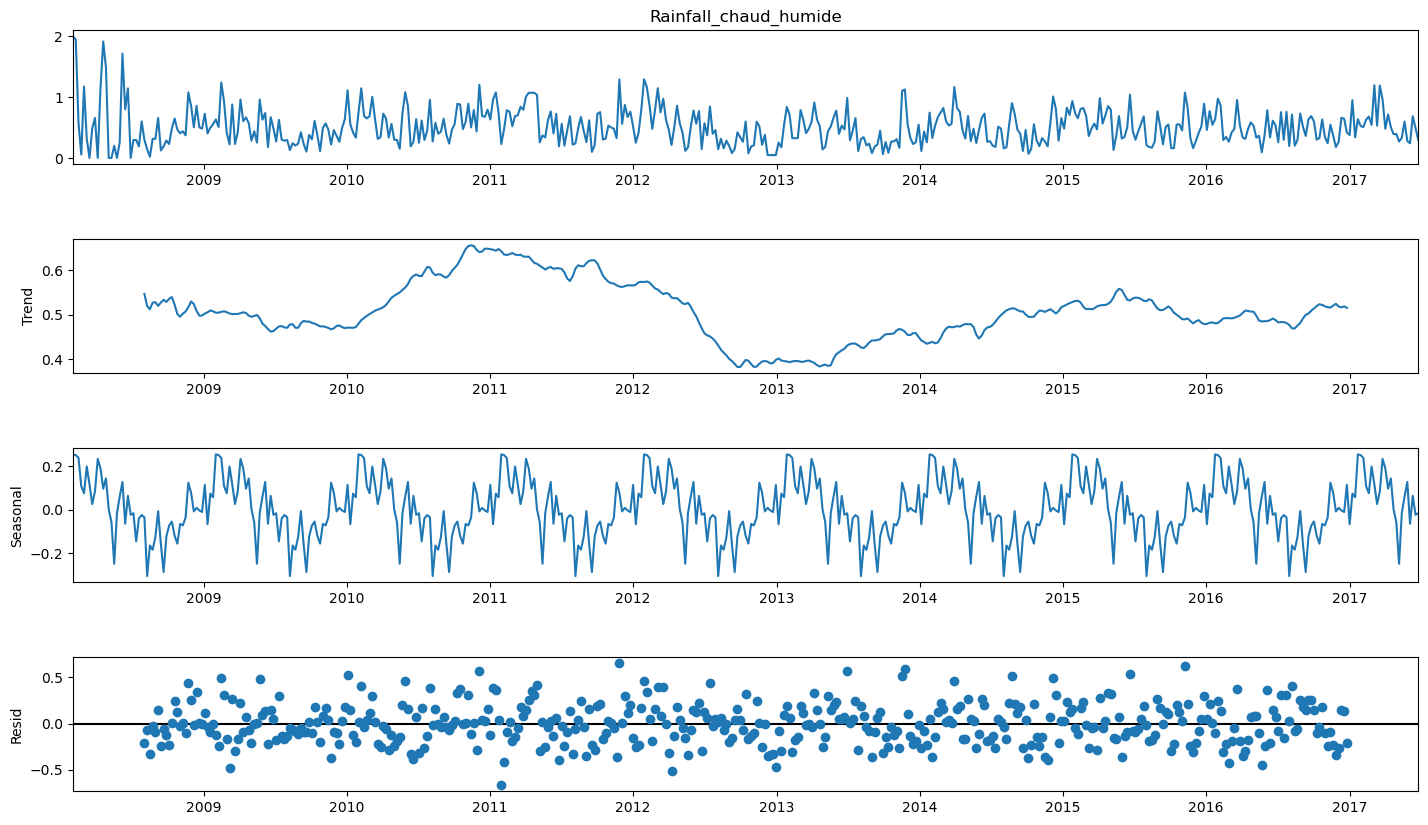

In [60]:
# décomposition automatique de la série temporelle identifiant la tendance, la saisonalité et le résidu
res = seasonal_decompose(data_max_obs_week.iloc[:,0], period=52, model='additive')
fig = res.plot()
fig.set_size_inches((16, 9));

- La tendance met en évidence les années de faibles et fortes précipitation,
- La saisonalité conserve une ampleur constante au cours du temps et correspond à un phénomène de période annuelle (soit 52 semaines environ),
- Le résidu ne présente pas de grandes variations en fonction du temps, il peut être assimilé à une suite de variables aléatoires non corrélées et de variance finie, c'est à dire à un bruit blanc faible.

### Série ré-échantillonnée sur une base mensuelle moyennée

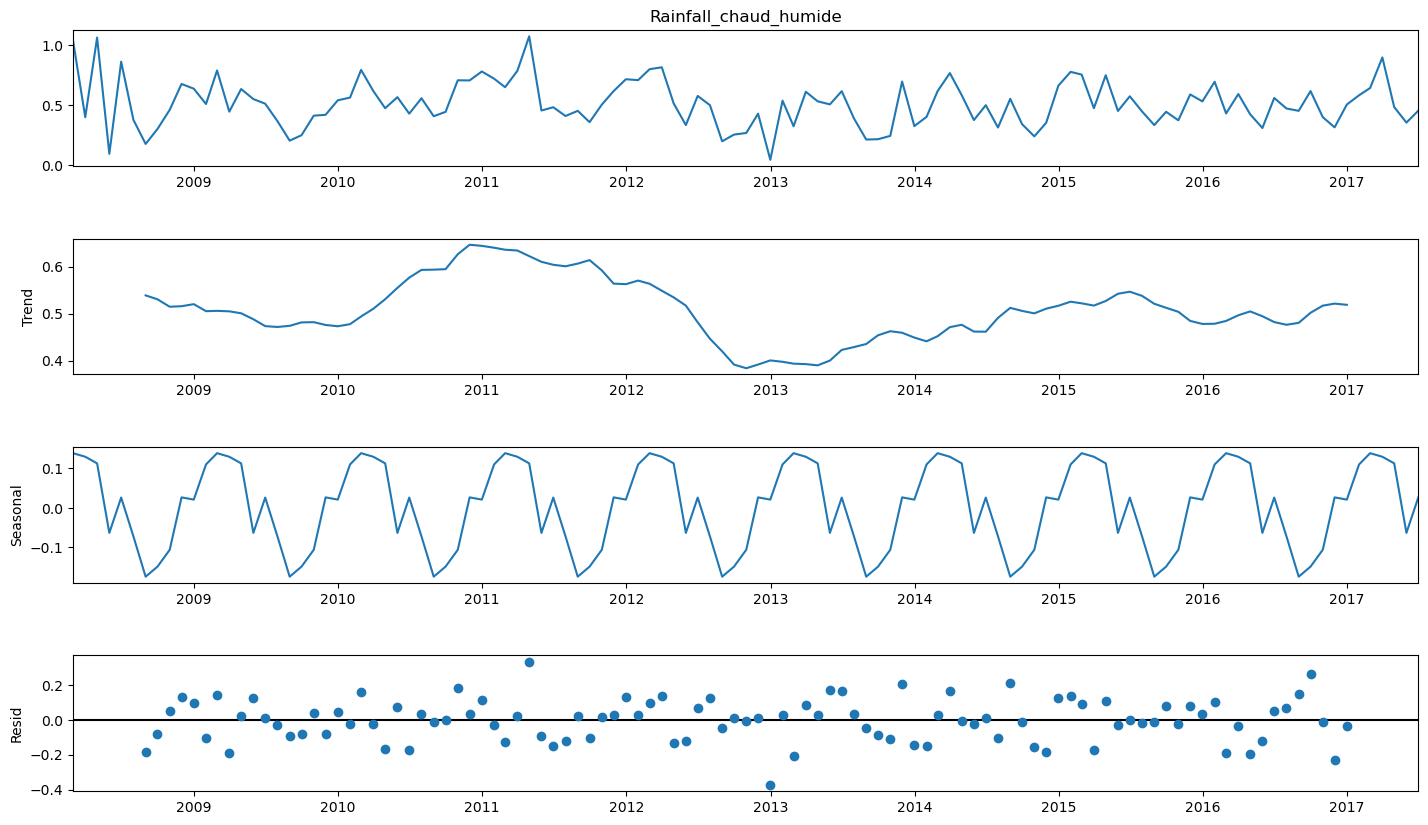

In [61]:
# décomposition automatique de la série temporelle identifiant la tendance, la saisonalité et le résidu
res = seasonal_decompose(data_max_obs_month.iloc[:,0], period=12, model='additive')
fig = res.plot()
fig.set_size_inches((16, 9));

- La tendance met en évidence les années de faibles et fortes précipitation,
- La saisonalité conserve une ampleur constante au cours du temps et correspond à un phénomène de période annuelle (soit 52 semaines environ),
- Le résidu ne présente pas de grandes variations en fonction du temps, il peut être assimilé à une suite de variables aléatoires non corrélées et de variance finie, c'est à dire à un bruit blanc faible.

# Entraînement d'un modèle SARIMA

## Autocorrélation et différenciation

### Série ré-échantillonnée sur une base hebdomadaire moyennée

In [62]:
# différenciation simple
data_max_obs_week_1 = data_max_obs_week.diff().dropna()  

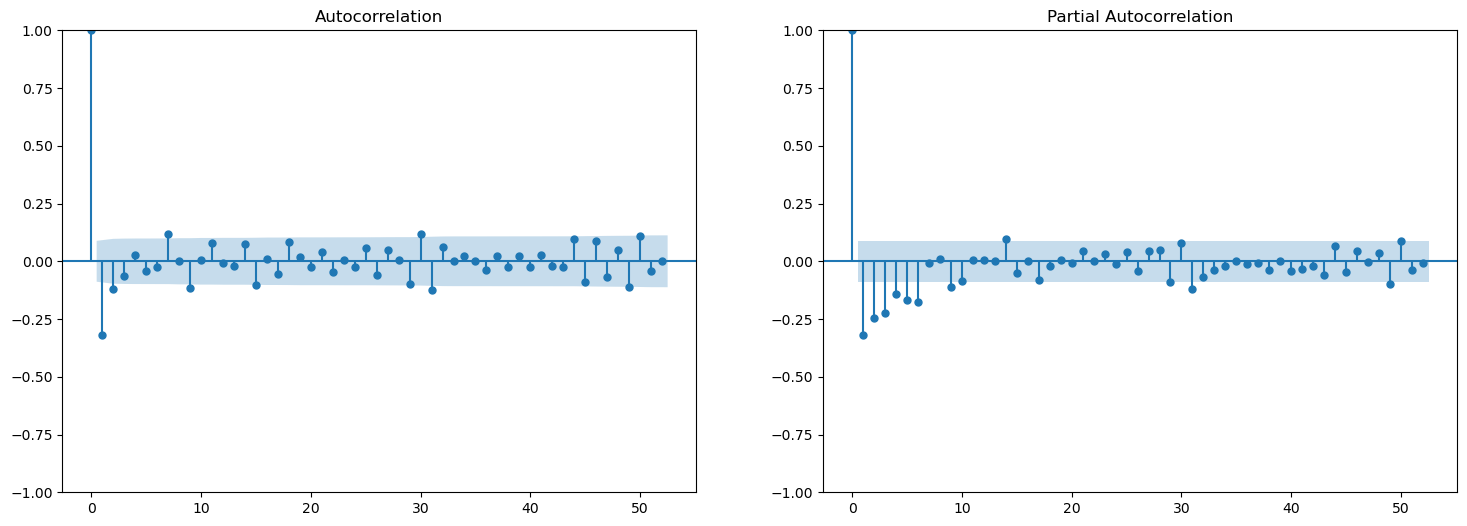

In [63]:
# affichage sur 52 décalages des autocorrélogrammes simple et partiel de la série différenciée
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

plot_acf(data_max_obs_week_1.iloc[:,0], lags=52, ax=ax1)
plot_pacf(data_max_obs_week_1.iloc[:,0], lags=52, ax=ax2);

- L'autocorrélation simple (ACF) s'annule après l'ordre 1
- L'autocorrélation partielle (PACF) tend vers 0

On choisit donc un modèle MA(1), ce qui est équivalent à un ARMA(0,1).

In [64]:
# différenciation d'ordre 52
data_max_obs_week_2 = data_max_obs_week_1.diff(periods=52).dropna()

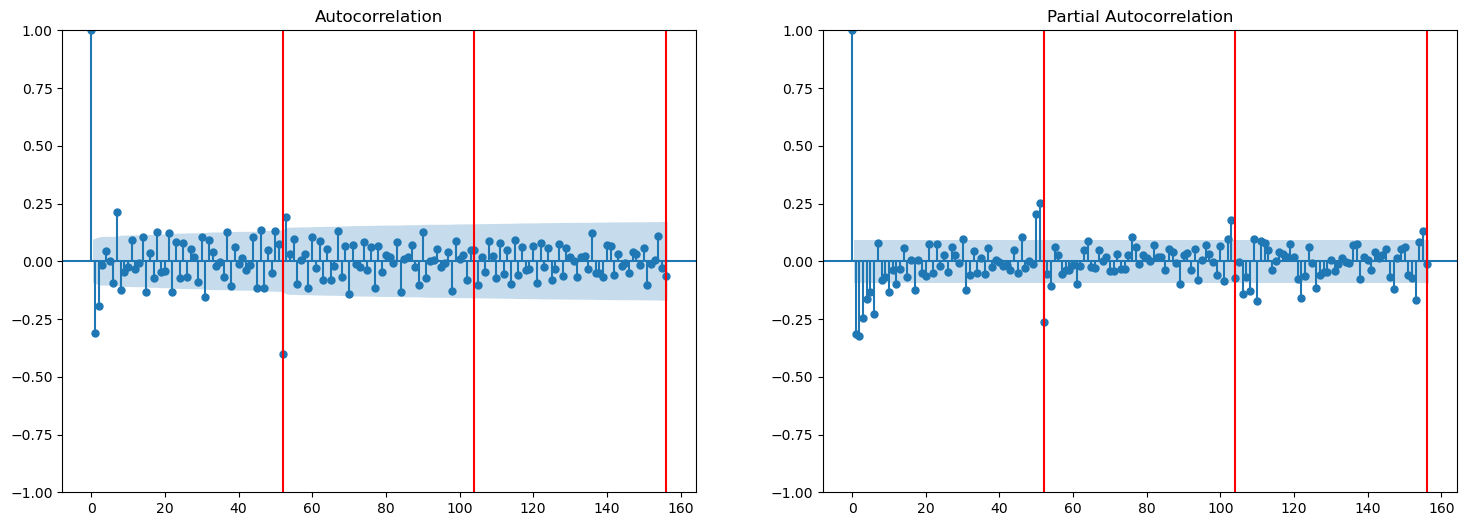

In [65]:
# affichage sur 52*3 décalages des autocorrélogrammes simple et partiel de la série doublement différenciée
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

plot_acf(data_max_obs_week_2.iloc[:,0], lags=52*3, ax=ax1)
ax1.axvline(x=52, color='red')
ax1.axvline(x=52*2, color='red')
ax1.axvline(x=52*3, color='red')
plot_pacf(data_max_obs_week_2.iloc[:,0], lags=52*3, ax=ax2)
ax2.axvline(x=52, color='red')
ax2.axvline(x=52*2, color='red')
ax2.axvline(x=52*3, color='red');

- L'autocorrélation simple (ACF) s'annule après l'ordre 1
- L'autocorrélation partielle (PACF) tend vers 0

On choisit donc un modèle MA(1), ce qui est équivalent à un ARMA(0,1).

### Série ré-échantillonnée sur une base mensuelle moyennée

In [66]:
# différenciation simple
data_max_obs_month_1 = data_max_obs_month.diff().dropna()  

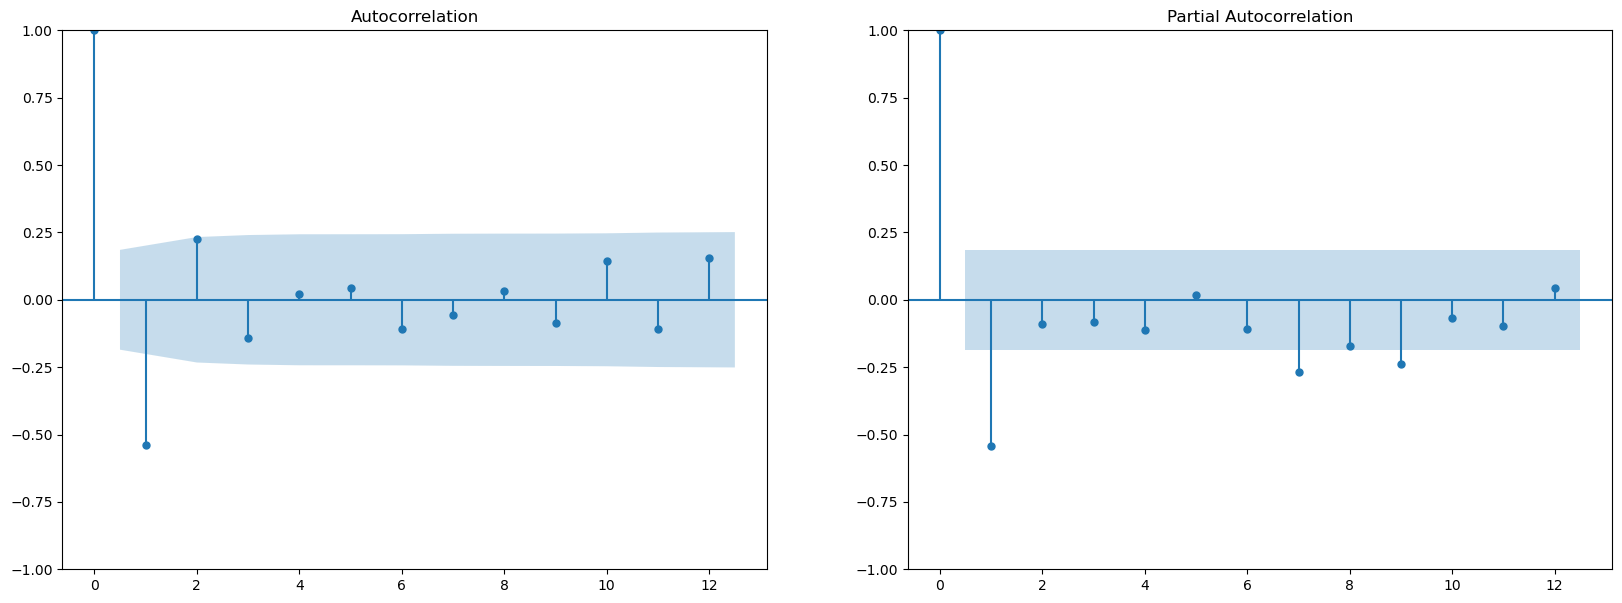

In [67]:
# affichage sur 12 décalages des autocorrélogrammes simple et partiel de la série différenciée
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(data_max_obs_month_1.iloc[:,0], lags=12, ax=ax1)
plot_pacf(data_max_obs_month_1.iloc[:,0], lags=12, ax=ax2);

- L'autocorrélation simple (ACF) s'annule après l'ordre 1
- L'autocorrélation partielle (PACF) tend vers 0

On choisit donc un modèle MA(1), ce qui est équivalent à un ARMA(0,1).

In [68]:
# différenciation d'ordre 12
data_max_obs_month_2 = data_max_obs_month_1.diff(periods=12).dropna()

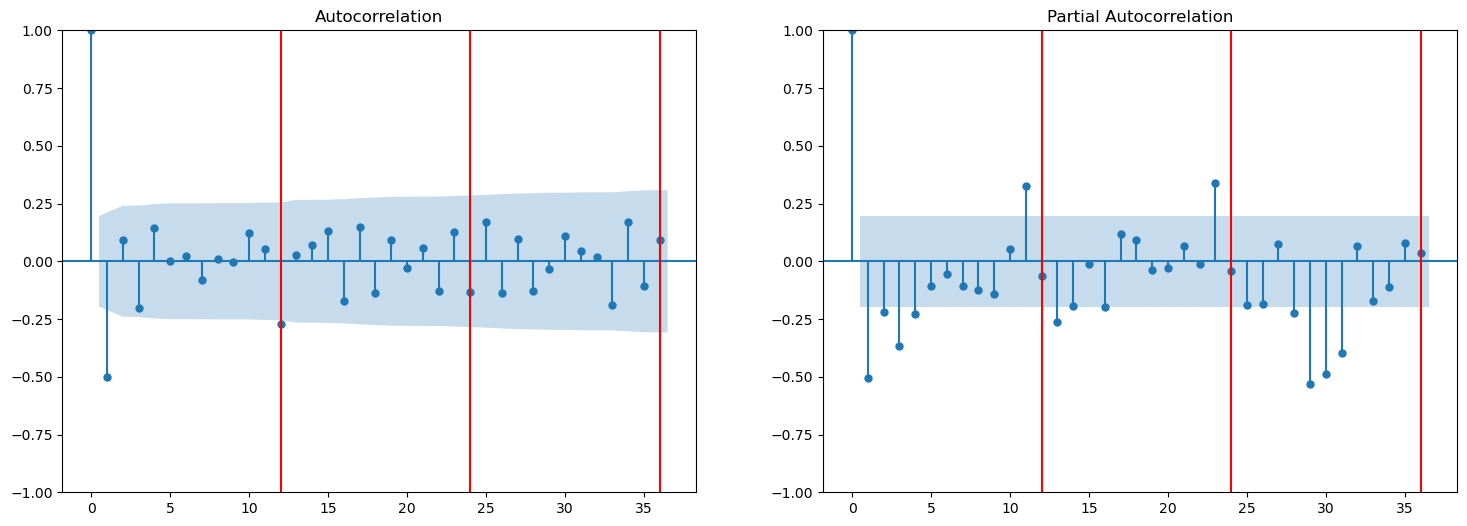

In [69]:
# affichage sur 12*3 décalages des autocorrélogrammes simple et partiel de la série doublement différenciée
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

plot_acf(data_max_obs_month_2.iloc[:,0], lags=12*3, ax=ax1)
ax1.axvline(x= 12, color='red')
ax1.axvline(x= 12*2, color='red')
ax1.axvline(x= 12*3, color='red')
plot_pacf(data_max_obs_month_2.iloc[:,0], lags=12*3, ax=ax2)
ax2.axvline(x= 12, color='red')
ax2.axvline(x= 12*2, color='red')
ax2.axvline(x= 12*3, color='red');

- L'autocorrélation simple (ACF) s'annule après l'ordre 1
- L'autocorrélation partielle (PACF) tend vers 0

On choisit donc un modèle MA(1), ce qui est équivalent à un ARMA(0,1).

## Entraînement et sélection du modèle

### Série ré-échantillonnée sur une base hebdomadaire moyennée

In [70]:
# instantiation d'un modèle SARIMAX correspondant au modèle SARIMA(1,1,1)(0,1,1)_52
model = sm.tsa.SARIMAX(data_max_obs_week.iloc[:,0], order=(1,1,1), seasonal_order=(0,1,1,52))
sarima = model.fit()
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:              Rainfall_chaud_humide   No. Observations:                  491
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -105.880
Date:                            Sat, 12 Nov 2022   AIC                            219.760
Time:                                    06:02:29   BIC                            236.089
Sample:                                02-03-2008   HQIC                           226.203
                                     - 06-25-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2417      0.044      5.451      0.000       0.155       0.329
ma.L1         -0.9717      0.016   

- La colonne qui nous intéresse le plus est la  4ème colonne  (P>|z|) qui indique la p-valeur pour la significativité de chaque paramètre. Ici nous voyons que le paramètre "ma.S.L52" a une p-valeur bien supérieure à 5%. Nous pouvons donc considérer ce terme comme non significatif et le supprimer pour simplifier le modèle.

- Le test de Ljung-Box est un test de blancheur des résidus. C'est un test statistique qui vise à rejeter ou non l'hypothèse  H0: "Le résidu est un bruit blanc". Ici on lit sur la ligne Prob(Q) que la p-valeur de ce test est nulle, donc on rejette l'hypothèse.

- Le test de Jarque-Bera est un test de normalité. C'est un test statistique qui vise à rejeter ou non l'hypothèse H0: "Le résidu suit une distribution normale". Ici on lit sur la ligne Prob (JB) que la p-valeur du test est nulle, donc on rejette l'hypothèse.

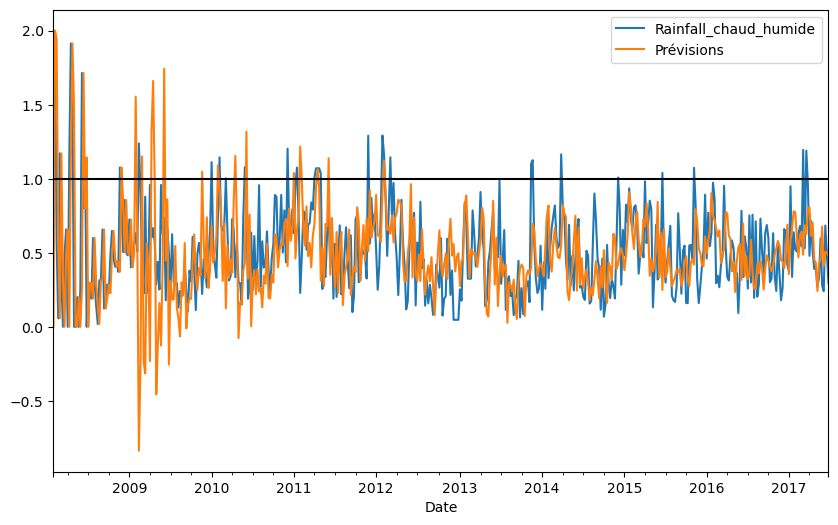

In [71]:
# affichage des observations et de la la prévision des précipitations à l'intérieur de l'échantillon
start_idx = 0
end_idx = start_idx + 9*52 + weeks_in_2017

data_max_obs_week['Prévisions'] = sarima.predict(start=start_idx, end=end_idx)
data_max_obs_week[['Rainfall_'+climate_with_max_obs, 'Prévisions']].plot(figsize=(10,6))
plt.axhline(y=1, color='black');

In [72]:
# prédiction du modèle avec intervalle de confiance
prediction = sarima.get_forecast(steps=52).summary_frame()  

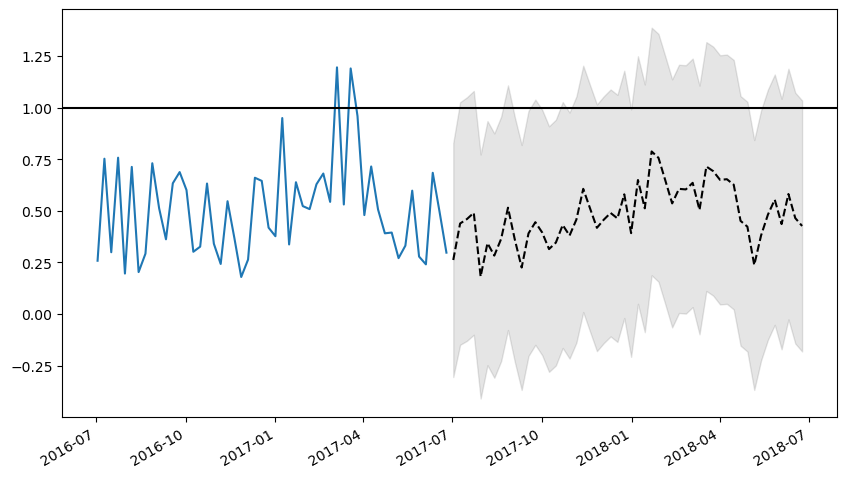

In [73]:
# visualisation de la moyenne et de l'intervalle de confiance pour la prévision des précipitations hors échantillon 
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(data_max_obs_week.iloc[-52:,0])
prediction['mean'].plot(ax=ax, style='k--', figsize=(10,6)) 
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.axhline(y=1, color='black');

### Série ré-échantillonnée sur une base mensuelle moyennée

In [74]:
# instantiation d'un modèle SARIMAX correspondant au modèle SARIMA(0,1,1)(0,1,1)_12
model = sm.tsa.SARIMAX(data_max_obs_month.iloc[:,0], order=(0,1,1), seasonal_order=(0,1,1,12))
sarima = model.fit()
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:              Rainfall_chaud_humide   No. Observations:                  113
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  26.573
Date:                            Sat, 12 Nov 2022   AIC                            -47.146
Time:                                    06:02:30   BIC                            -39.330
Sample:                                02-29-2008   HQIC                           -43.983
                                     - 06-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8518      0.054    -15.672      0.000      -0.958      -0.745
ma.S.L12      -0.7366      0.136   

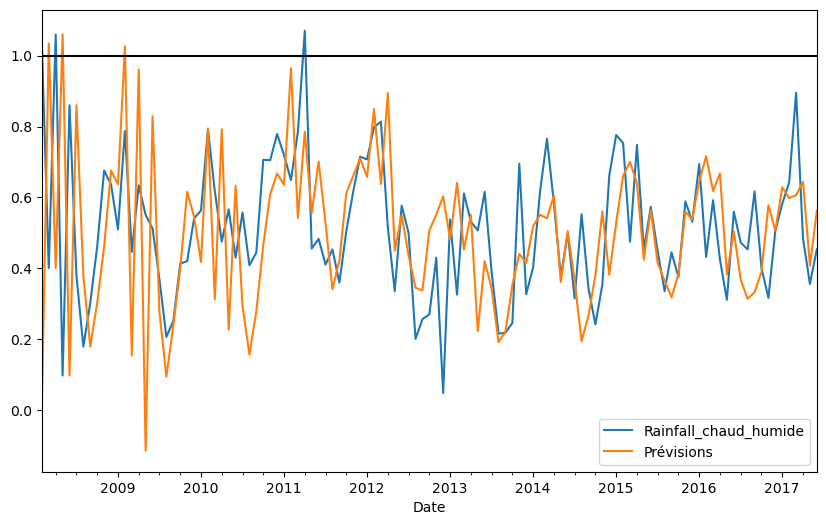

In [75]:
# affichage des observations et de la la prévision des précipitations à l'intérieur de l'échantillon
start_idx = 0
end_idx = start_idx + 9*12 + months_in_2017

data_max_obs_month['Prévisions'] = sarima.predict(start=start_idx, end=end_idx)
data_max_obs_month[['Rainfall_'+climate_with_max_obs,'Prévisions']].plot(figsize=(10,6))
plt.axhline(y=1, color='black');

In [76]:
# prédiction du modèle avec intervalle de confiance
prediction = sarima.get_forecast(steps=12).summary_frame()

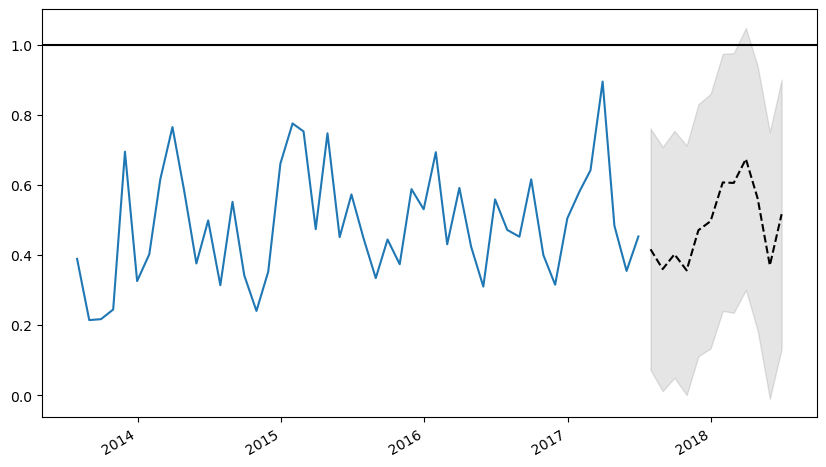

In [77]:
# visualisation de la moyenne et de l'intervalle de confiance pour la prévision des précipitations hors échantillon
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(data_max_obs_month.iloc[-48:,0])
prediction['mean'].plot(ax=ax, style='k--', figsize=(10,6)) 
ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1)
plt.axhline(y=1, color='black');

## Conclusion

La série temporelle filtrée et ré-échantillée sur une base mensuelle moyennée donne les meilleurs résultats.